In [1]:
# Only these three packages are allowed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class FLD:
    def __init__(self):
        self.class_means = None
        self.sw = None
        self.sb = None
        self.w = None
        self.n_classes = None
        self.n_features = None

    def fit(self, X, y):
        classes = np.unique(y)
        self.n_classes = len(classes)
        self.n_features = X.shape[1]
        
        # Calculate class means
        self.class_means = np.zeros((self.n_classes, self.n_features)) #(3,2)
        for c in classes:
            self.class_means[c] = np.mean(X[y==c], axis=0)
        print("self.class_means = \n", self.class_means)
            
        # Calculate Sw
        self.sw = np.zeros((self.n_features, self.n_features)) #(2,2)
        for c in classes:
            class_X = X[y==c] #(327,2)
            class_mean = self.class_means[c] #(2,)
            class_scatter = np.zeros((self.n_features, self.n_features))
            for x in class_X:
                x_diff = x - class_mean
                class_scatter += np.outer(x_diff, x_diff)
            self.sw += class_scatter
        print("self.sw = \n", self.sw)
        
        # Calculate Sb
        self.sb = np.zeros((self.n_features, self.n_features))
        total_mean = np.mean(X, axis=0) #(2,)
        for c in classes:
            n = X[y==c].shape[0]
            mean_diff = self.class_means[c] - total_mean
            self.sb += n * np.outer(mean_diff, mean_diff)
        print("self.sb = \n", self.sb)    
      
        # Compute eigenvalues and eigenvectors of (Sw^-1)*Sb
        S = np.linalg.inv(self.sw).dot(self.sb)
        eigenvalues, eigenvectors = np.linalg.eig(S)
        sorted_indices = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sorted_indices]
        eigenvectors = eigenvectors[:,sorted_indices]
        self.w = eigenvectors[:, 0]
        self.w = self.w.reshape(self.n_features, -1)
        print("self.w = \n", self.w)
        print("------------------------------------------------")

#-------------------------------------------------------------------------------
    
    def predict_using_class_mean(self, X, y, X_test):
        classes = np.unique(y)
        n_classes = len(classes)
        n_features = X.shape[1]
        class_means = np.zeros((n_classes, n_features))
        class_means_prj = np.zeros((n_classes, n_features))
        for c in classes:
            class_means[c] = np.mean(X[y==c], axis=0)
            class_means_prj[c] = np.dot(class_means[c], self.w)
        y_pred = np.zeros(X_test.shape[0])
        X_test_prj = np.dot(X_test, self.w)
        for i in range(len(X_test)):
            dist = []
            for c in classes:
                distance = ((X_test_prj[i] - class_means_prj[c])**2)[0]
                dist.append(distance)
            min_index = np.argmin(dist)
            min_label = classes[min_index]
            y_pred[i] = min_label
        return y_pred
        
    def predict_using_knn(self, X, y, X_test, k=1):
        y_pred = np.zeros(X_test.shape[0])
        X_prj = np.dot(X, self.w)
        X_test_prj = np.dot(X_test, self.w)
        for i in range(len(X_test)):
            dist = []
            for j in range(len(X)):
                distance = ((X_test_prj[i] - X_prj[j])**2)[0]
                dist.append(distance)
            sort_index = np.argsort(dist)
            sort_index = sort_index[0:k]
            neighbors = X[sort_index] 
            neighbors_label = y[sort_index]
            values, counts = np.unique(neighbors_label, return_counts=True)
            max_index = np.argmax(counts)
            max_label = values[max_index]
            y_pred[i] = max_label
        return y_pred
    
    def show_confusion_matrix(self, y_true, y_pred):
        labels = np.unique(np.concatenate((y_true, y_pred)))
        cm = np.zeros((len(labels), len(labels)), dtype=int)
        y_true = y_true.reshape(-1,1)
        y_pred = y_pred.reshape(-1,1)
        for i in range(len(y_true)):
            true_label_index = np.where(labels == y_true[i])[0][0]
            pred_label_index = np.where(labels == y_pred[i])[0][0]
            cm[true_label_index][pred_label_index] += 1
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens) 
        ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xlabel='Predicted label', ylabel='True label')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color="white" if cm[i, j]>cm.max()/2 else "black")
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Count', rotation=-90, va="bottom") 
        plt.title("Confusion Matrix")
        plt.show()

    def plot_projection(self, X, y):
        m = self.w[1] / self.w[0]
        b = np.round(self.w[1], 4) + 2
        x_line = np.linspace(-6, 4, 100)
        y_line = m * x_line + b
        X_prj = (m * X[:,1] + X[:,0] - m * b) / (m**2 + 1)
        Y_prj = (m**2 * X[:,1] + m * X[:,0] + b) / (m**2 + 1)
        plt.figure(figsize=(8, 6))
        plt.plot(x_line, y_line, linewidth=1)
        plt.scatter(X[:,0], X[:,1], c=y, marker='.')
        plt.scatter(X_prj, Y_prj, c=y, marker='.', s=1)
        plt.plot([X_prj, X[:,0]], [Y_prj, X[:,1]], linestyle="-", color='#808080', linewidth=0.3, alpha=0.2)
        plt.title("Projection Line: m=%f, b=%f" %(m, b))
        
    def accuracy_score(self, y, y_pred):
        return np.mean(y_pred == y)
    
    def get_w(self):
        return self.w
        

In [3]:
class MulticlassLogisticRegression:
    def __init__(self):
        self.n_classes = None
        self.n_features = None
        self.n_samples = None
        self.weights = None
        self.bias = None
        self.learning_rate = None
        self.batch_size = None
        self.n_epochs = None
        self.train_loss = []
    
    def fit(self, X, y, batch_size=16, lr=0.01, n_epoch=1000):
        self.n_classes = len(np.unique(y))
        self.n_samples, self.n_features = X.shape
        self.weights = np.zeros((self.n_features, self.n_classes))
        self.bias = np.zeros((1, self.n_classes))
        self.learning_rate = lr
        self.batch_size = batch_size
        self.n_epochs = n_epoch
        
        y = self.one_hot_encode(y)
        n_batches = X.shape[0] // self.batch_size
        for epoch in range(self.n_epochs):
            batch_loss = 0
            for i in range(n_batches):
                start = i * self.batch_size
                end = (i + 1) * self.batch_size
                X_batch = X[start:end]
                y_batch = y[start:end]
                y_pred = self.softmax(np.dot(X_batch, self.weights) + self.bias)
                loss = self.cross_entropy_loss(y_batch, y_pred)
                batch_loss += loss
                grad_w = np.dot(X_batch.T, y_pred - y_batch) / self.batch_size
                grad_b = np.mean(y_pred - y_batch, axis=0, keepdims=True)
                self.weights -= self.learning_rate * grad_w
                self.bias -= self.learning_rate * grad_b
            batch_loss /= len(X)
            self.train_loss.append(batch_loss)
    
    def one_hot_encode(self, y):
        one_hot = np.zeros((y.shape[0], self.n_classes))
        for i in range(y.shape[0]):
            one_hot[i, int(y[i])] = 1
        return one_hot
    
    def softmax(self, x):
        exps = np.exp(x)
        return exps / np.sum(exps, axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred), axis=1))
    
    def predict(self, X):
        return np.argmax(self.softmax(np.dot(X, self.weights) + self.bias), axis=1)
    
    def evaluate(self, X, y):
        y_pred_lable = self.predict(X)
        return np.mean(y_pred_lable == y)
    
    def accuracy_score(self, y_true, y_pred):
        return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

    def plot_curve(self): 
        plt.clf()        
        plt.plot(self.train_loss)
        plt.title("Logistic Regression - Loss vs Iterations")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()
    
    def show_confusion_matrix(self, X, y_true):
        y_pred = self.predict(X)
        labels = np.unique(np.concatenate((y_true, y_pred)))
        cm = np.zeros((len(labels), len(labels)), dtype=int)
        y_true = y_true.reshape(-1,1)
        y_pred = y_pred.reshape(-1,1)
        for i in range(len(y_true)):
            true_label_index = np.where(labels == y_true[i])[0][0]
            pred_label_index = np.where(labels == y_pred[i])[0][0]
            cm[true_label_index][pred_label_index] += 1
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Greens) 
        ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]),
               xlabel='Predicted label', ylabel='True label')
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, cm[i, j], ha="center", va="center",
                        color="white" if cm[i, j]>cm.max()/2 else "black")
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Count', rotation=-90, va="bottom") 
        plt.title("Confusion Matrix")
        plt.show()

# Prepare data for Q1 ~ Q12

X_train (1000, 2)
X_test (1000, 2)
y_train (1000,)
y_test (1000,)


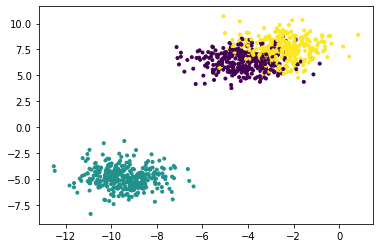

In [4]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_blob_train.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_blob_test.csv"))

X_train = df_train[['Feature1', 'Feature2']].to_numpy()
X_test = df_test[['Feature1', 'Feature2']].to_numpy()
y_train = df_train[['Target']].to_numpy().ravel()
y_test = df_test[['Target']].to_numpy().ravel()
print("X_train", X_train.shape)
print("X_test",  X_test.shape)
print("y_train", y_train.shape)
print("y_test",  y_test.shape)

plt.scatter(X_train[:,0], X_train[:,1], c=y_train, marker='.')

# MultiClass Logistic Regression

Training acc:  0.897
Testing acc:  0.884


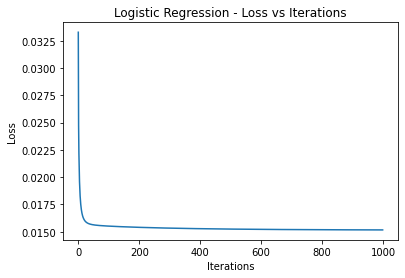

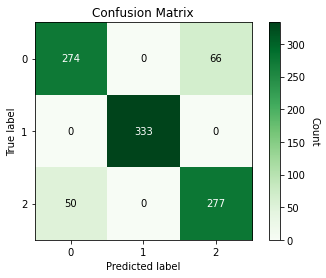

In [5]:
logistic_reg = MulticlassLogisticRegression()
logistic_reg.fit(X_train, y_train, batch_size=16, lr=0.01, n_epoch=1000)
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))
print('Testing acc: ', logistic_reg.evaluate(X_test, y_test))
logistic_reg.plot_curve()
logistic_reg.show_confusion_matrix(X_test, y_test)

# Fisher's Linear Discriminant Analysis

In [6]:
# fld = FLD()
# fld.fit(X_train, y_train)
# fld.plot_projection(X_train, y_train)
# for k in range(1, 11):
#     y_pred = fld.predict_using_knn(X_train, y_train, X_test, k=k)
#     acc = fld.accuracy_score(y_test, y_pred)
#     print(f"k={k} -> Accuracy of test-set {acc}")
# print("-------------------------------------------------------------------")
# y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
# acc = fld.accuracy_score(y_test, y_pred)
# print(f"Testing acc: {acc} ")
# fld.show_confusion_matrix(y_test, y_pred)

In [7]:
fld = FLD()
fld.fit(X_train, y_train)

print("Class mean vector: \n", fld.class_means)
print("Within-class scatter matrix SW: \n", fld.sw)
print("Between-class scatter matrix SB: \n", fld.sb)
print("W: \n", fld.w)

self.class_means = 
 [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]
self.sw = 
 [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]
self.sb = 
 [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]
self.w = 
 [[-0.44115384]
 [-0.8974315 ]]
------------------------------------------------
Class mean vector: 
 [[-4.17505764  6.35526804]
 [-9.43385176 -4.87830741]
 [-2.54454008  7.53144179]]
Within-class scatter matrix SW: 
 [[1052.70745046  -12.5828441 ]
 [ -12.5828441   971.29686189]]
Between-class scatter matrix SB: 
 [[ 8689.12907035 16344.86572983]
 [16344.86572983 31372.93949414]]
W: 
 [[-0.44115384]
 [-0.8974315 ]]


FLD using class mean, accuracy:  0.861


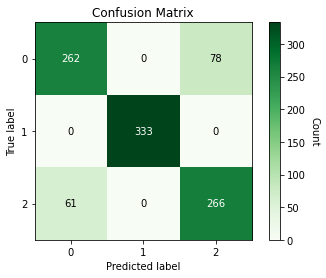

In [8]:
## Predict_using_class_mean
y_pred = fld.predict_using_class_mean(X_train, y_train, X_test)
print("FLD using class mean, accuracy: ", fld.accuracy_score(y_test, y_pred))
fld.show_confusion_matrix(y_test, y_pred)

In [9]:
## Predict_using_knn
y_pred_k1 = fld.predict_using_knn(X_train, y_train, X_test, k=1)
print("FLD using knn (k=1), accuracy: ", fld.accuracy_score(y_test, y_pred_k1))
y_pred_k2 = fld.predict_using_knn(X_train, y_train, X_test, k=2)
print("FLD using knn (k=2), accuracy: ", fld.accuracy_score(y_test, y_pred_k2))
y_pred_k3 = fld.predict_using_knn(X_train, y_train, X_test, k=3)
print("FLD using knn (k=3), accuracy: ", fld.accuracy_score(y_test, y_pred_k3))
y_pred_k4 = fld.predict_using_knn(X_train, y_train, X_test, k=4)
print("FLD using knn (k=4), accuracy: ", fld.accuracy_score(y_test, y_pred_k4))
y_pred_k5 = fld.predict_using_knn(X_train, y_train, X_test, k=5)
print("FLD using knn (k=5), accuracy: ", fld.accuracy_score(y_test, y_pred_k5))

FLD using knn (k=1), accuracy:  0.822
FLD using knn (k=2), accuracy:  0.819
FLD using knn (k=3), accuracy:  0.843
FLD using knn (k=4), accuracy:  0.84
FLD using knn (k=5), accuracy:  0.862


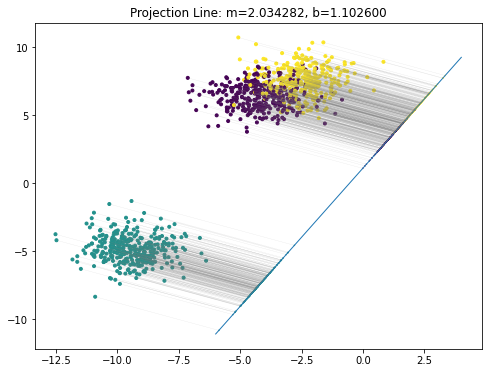

In [10]:
fld.plot_projection(X_train, y_train)

# Train your own model on provided dataset.
You can only using 1) **Fisher's Linear Discriminant** or 2) **Logistic Regression** that you have implemented above.

   Feature1  Feature2  Feature3  Feature4  Target
0   0.00668   0.00192     0.682     0.996     2.0
1   0.00680   0.00106     0.503     0.996     1.0
2   0.00742   0.00106     0.482     0.991     1.0
3   0.00685   0.00178     0.650     0.998     2.0
4   0.00680   0.00163     0.623     0.996     2.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1703 entries, 0 to 1702
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Feature1  1703 non-null   float64
 1   Feature2  1703 non-null   float64
 2   Feature3  1703 non-null   float64
 3   Feature4  1703 non-null   float64
 4   Target    1703 non-null   float64
dtypes: float64(5)
memory usage: 66.6 KB
None 

          Feature1     Feature2     Feature3     Feature4       Target
count  1703.000000  1703.000000  1703.000000  1703.000000  1703.000000
mean      0.007234     0.001741     0.617571     0.995216     0.893130
std       0.000672     0.000503     0.082357     0.004149 

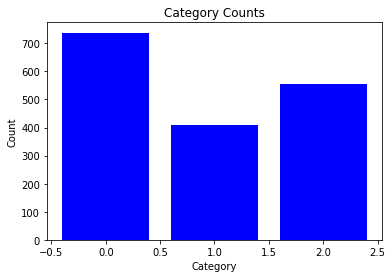

------------------------------------------------------------------------
          Feature1  Feature2  Feature3  Feature4    Target
Feature1  1.000000  0.532584  0.224169  0.214851 -0.657016
Feature2  0.532584  1.000000  0.938422  0.431155 -0.477465
Feature3  0.224169  0.938422  1.000000  0.421574 -0.265032
Feature4  0.214851  0.431155  0.421574  1.000000 -0.215316
Target   -0.657016 -0.477465 -0.265032 -0.215316  1.000000


In [11]:
df_train = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_train.csv"))
df_val   = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_val.csv"))
df_test  = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_test.csv"))

## Statistic Info
print(df_train.head(), "\n")
print(df_train.info(), "\n")
print(df_train.describe())
print("------------------------------------------------------------------------")

## Category Counts
data = df_train
counts = data['Target'].value_counts()
fig, ax = plt.subplots()
ax.bar(counts.index, counts.values, color='blue')
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_title('Category Counts')
plt.show()
print("------------------------------------------------------------------------")

## Correlation Coefficient
corr = data.corr()
print(corr)

In [12]:
def Feature_engineering(data):                    
    data = (data - data.mean()) / data.std()            
    data['11'] = data['Feature1'] * data['Feature1']
    data['22'] = data['Feature2'] * data['Feature2']
    data['33'] = data['Feature3'] * data['Feature3']
    data['44'] = data['Feature4'] * data['Feature4']
    data['12'] = data['Feature1'] * data['Feature2']
    data['13'] = data['Feature1'] * data['Feature3']
    data['14'] = data['Feature1'] * data['Feature4']
    data['23'] = data['Feature2'] * data['Feature3']
    data['24'] = data['Feature2'] * data['Feature4']
    data['34'] = data['Feature3'] * data['Feature4']    
    data['feature1_bin'] = pd.cut(data['Feature1'], bins=5, labels=False)
    data['feature2_bin'] = pd.cut(data['Feature2'], bins=5, labels=False)
    data['feature3_bin'] = pd.cut(data['Feature3'], bins=5, labels=False)
    data['feature4_bin'] = pd.cut(data['Feature4'], bins=5, labels=False)
    data = pd.get_dummies(data)
    return data

used_feature = ['Feature1', 'Feature2', 'Feature3','Feature4']
target_feature = ['Target']

X_train = df_train[used_feature]
X_val = df_val[used_feature]
X_test = df_test[used_feature]
y_train = df_train[target_feature]
y_val = df_val[target_feature]
print("X_train", X_train.shape)
print("X_val",  X_val.shape)
print("X_test",  X_test.shape)
print("y_train", y_train.shape)
print("y_val",  y_val.shape)
print("-----------------------------")

X_train = Feature_engineering(X_train).to_numpy()
X_val = Feature_engineering(X_val).to_numpy()
X_test = Feature_engineering(X_test).to_numpy()
y_train = y_train.to_numpy().ravel().astype(int)
y_val = y_val.to_numpy().ravel().astype(int)
print("X_train", X_train.shape)
print("X_val",  X_val.shape)
print("X_test",  X_test.shape)
print("y_train", y_train.shape)
print("y_val",  y_val.shape)


X_train (1703, 4)
X_val (730, 4)
X_test (5677, 4)
y_train (1703, 1)
y_val (730, 1)
-----------------------------
X_train (1703, 18)
X_val (730, 18)
X_test (5677, 18)
y_train (1703,)
y_val (730,)


Training acc:  0.9201409277745156
Validation acc:  0.9232876712328767


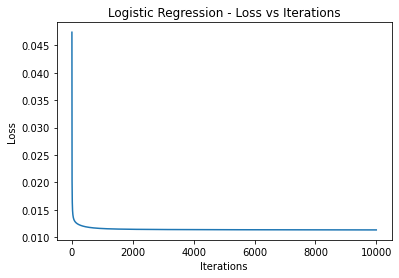

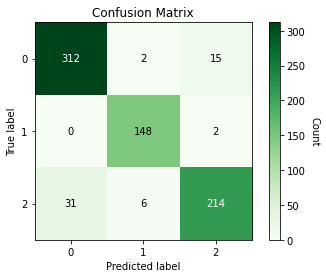

In [13]:
logistic_reg = MulticlassLogisticRegression()
logistic_reg.fit(X_train, y_train, batch_size=16, lr=0.005, n_epoch=10000)
print('Training acc: ', logistic_reg.evaluate(X_train, y_train))
print('Validation acc: ', logistic_reg.evaluate(X_val, y_val))
logistic_reg.plot_curve()
logistic_reg.show_confusion_matrix(X_val, y_val)


In [14]:
test_pred = logistic_reg.predict(X_test)
print("test_pred shape: ", test_pred.shape)
assert len(test_pred) == len(X_test)

test_pred shape:  (5677,)


# Output the csv file

In [15]:
df_test = pd.DataFrame(pd.read_csv("./dataset/PR_HW2_test.csv"))
df_test["Target"] = test_pred
print(df_test)
df_test.to_csv("109550090_prediction.csv")

      Feature1  Feature2  Feature3  Feature4  Target
0      0.00699  0.000877     0.451     0.994       1
1      0.00736  0.001370     0.549     0.998       1
2      0.00687  0.001420     0.580     0.992       2
3      0.00752  0.002520     0.737     0.996       0
4      0.00685  0.000910     0.464     0.992       1
...        ...       ...       ...       ...     ...
5672   0.00697  0.002030     0.687     0.996       0
5673   0.00841  0.002140     0.642     0.997       0
5674   0.00700  0.001040     0.491     0.995       1
5675   0.00677  0.001580     0.615     0.995       2
5676   0.00683  0.001630     0.622     0.997       2

[5677 rows x 5 columns]
